<a href="https://colab.research.google.com/github/louiewang820/STATS447B-Project/blob/main/Damage_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## connect google drive to this notebook

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#change directory to google drive
%cd /content/drive/MyDrive 
#make a directory named ML2022
!mkdir ML2022 
#change directory to ML2022
%cd ./ML2022 

/content/drive/MyDrive
mkdir: cannot create directory ‘ML2022’: File exists
/content/drive/MyDrive/ML2022


In [3]:
# output the current directory
!pwd

/content/drive/MyDrive/ML2022


# clone data from github 

In [ ]:
!git clone https://github.com/louiewang820/STATS447B-Project.git

Cloning into 'STATS447B-Project'...
remote: Enumerating objects: 1988, done.
remote: Counting objects: 100% (1988/1988), done.
remote: Compressing objects: 100% (1984/1984), done.
remote: Total 1988 (delta 12), reused 1940 (delta 0), pack-reused 0
Receiving objects: 100% (1988/1988), 100.42 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (2003/2003), done.


# set the Hyperparameters (Change here)

In [4]:
# Hyperparameters
batch_size = 128
traning_set_ratio = 0.7
set_seed = 0
image_size = 224


# some imports 

In [21]:
import torchvision 
from torch import nn
# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
from PIL import Image 
from torchvision.transforms import ToTensor
from pandas import DataFrame as df
import os
import pandas as pd
from skimage import io

import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.modules.module import Module


from torchvision import datasets, transforms
import torchvision.models as models

# Create a new CSV file to label the car conditions


In [6]:
text_data = pd.read_csv("/content/drive/MyDrive/ML2022/STATS447B-Project/dataset/sample_submission.csv") # the csv files stores in your google drive(may vary)
text_data.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0


In [7]:
condition = text_data[["Image_path","Condition"]]
condition.head()

,Image_path,Condition
0,img_4513976.jpg,0
1,img_7764995.jpg,1
2,img_451308.jpg,0
3,img_7768372.jpg,1
4,img_7765274.jpg,1


# data augmentation (DON't run second time)

In [8]:
number_of_replicate = 12 # we need 12 replicates for each undamaged car image 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
class Arugumentation(Dataset):
    def __init__(self, csv_file, root_dir): 
        self.annotations = csv_file # csv_file is the one we created for labels above
        self.root_dir = root_dir # root_dir is the dir of image file 


    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]) # get the individual img path 
        image = Image.open(img_path) # return the image by call the Image.open(), the image is in RGB form
        y_label = torch.tensor(int(self.annotations.iloc[index, 1])) # change the label to tensor form
        
        return (image, y_label) # data set contains images and its label      

In [ ]:

!mkdir img_argu 
# create replicates of undamaged car images
def repulicate(data,number_of_replicate):
  for k in data:
    if k[1] == 0:  # if label is undamaged 
      i = 0 
      x = img_to_array(k[0])  # this is a Numpy array with shape (3, 150, 150)
      x = x.reshape((1,) + x.shape)
      for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/ML2022/img_argu', save_prefix='lena', save_format='jpg'):
        i += 1
        if i > (number_of_replicate-1):
          break 


mkdir: cannot create directory ‘img_argu’: File exists


In [ ]:
argu = Arugumentation(
    csv_file=condition,
    root_dir="/content/drive/MyDrive/data/CarImages", # may vary based on the location of image files 
    )
repulicate(argu,number_of_replicate)

# create labels for augmented data

In [9]:
directory = "/content/drive/MyDrive/ML2022/img_argu"
list1 = os.listdir(directory)
argu_file = pd.DataFrame(list(zip(list1, [0]*len(list1))),
               columns =['Image_path', 'label'])
argu_file

,Image_path,label
0,lena_0_628.jpg,0
1,lena_0_9978.jpg,0
2,lena_0_2255.jpg,0
3,lena_0_1225.jpg,0
4,lena_0_5230.jpg,0
...,...,...
1133,lena_0_9738.jpg,0
1134,lena_0_2008.jpg,0
1135,lena_0_3154.jpg,0
1136,lena_0_9942.jpg,0


# import dataset of Car images


In [10]:
trans_resize = transforms.Resize((image_size,image_size)) # set the resize function for RGB images

In [11]:

class Cars(Dataset):
    def __init__(self, csv_file, root_dir, transform=None,resize = None): 
        self.annotations = csv_file # csv_file is the one we created for labels above
        self.root_dir = root_dir # root_dir is the dir of image file 
        self.transform = transform # transform images to tensor form
        self.resize = resize # resize the tensor form of images

    def __len__(self):
        return len(self.annotations) # return the length of csv_file

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]) # get the individual img path 
        image = Image.open(img_path) # return the image by call the Image.open(), the image is in RGB form
        y_label = torch.tensor(int(self.annotations.iloc[index, 1])) # change the label to tensor form
        if self.resize:
          image = trans_resize(image) # resize the image 
        else:
          image = image # if not we keep the size unchanged 
        if self.transform:
          image = self.transform(image)  # if we decide to transform the image to tensor form
        
        return (image, y_label) # data set contains images and its label

In [12]:
dataset_original = Cars(
    csv_file=condition,
    root_dir="/content/drive/MyDrive/ML2022/STATS447B-Project/dataset/trainImages", # may vary based on the location of image files
    transform=transforms.ToTensor(),
    resize = True
    )
dataset_replicate = Cars(
    csv_file=argu_file,
    root_dir="/content/drive/MyDrive/ML2022/img_argu", # may vary based on the location of image files
    transform=transforms.ToTensor(),
    resize = True
    )
dataset = torch.utils.data.ConcatDataset([dataset_original, dataset_replicate])


In [13]:
print(len(dataset))

2537


# load data

In [14]:
tran_length = round(traning_set_ratio * len(dataset)) # set the length of training set
test_length = len(dataset) - tran_length # set the length of test set

In [15]:
torch.manual_seed(set_seed) # for reproducibility
train_set, test_set = torch.utils.data.random_split(dataset, [tran_length, test_length]) # split the dataset into training and testing
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)


In [16]:
dataset[1]

(tensor([[[0.4039, 0.4078, 0.4118,  ..., 0.7843, 0.7882, 0.7882],
          [0.4039, 0.4039, 0.4118,  ..., 0.7804, 0.7843, 0.7804],
          [0.4039, 0.4039, 0.4078,  ..., 0.7804, 0.7804, 0.7686],
          ...,
          [0.6471, 0.6471, 0.6510,  ..., 0.6471, 0.6471, 0.6471],
          [0.6471, 0.6471, 0.6510,  ..., 0.6471, 0.6471, 0.6471],
          [0.6471, 0.6471, 0.6549,  ..., 0.6431, 0.6431, 0.6431]],
 
         [[0.5098, 0.5137, 0.5176,  ..., 0.7882, 0.7961, 0.8039],
          [0.5098, 0.5098, 0.5176,  ..., 0.7843, 0.7922, 0.7961],
          [0.5098, 0.5098, 0.5137,  ..., 0.7843, 0.7882, 0.7843],
          ...,
          [0.6275, 0.6275, 0.6314,  ..., 0.6275, 0.6275, 0.6275],
          [0.6275, 0.6275, 0.6314,  ..., 0.6275, 0.6275, 0.6275],
          [0.6275, 0.6275, 0.6353,  ..., 0.6235, 0.6235, 0.6235]],
 
         [[0.5765, 0.5804, 0.5843,  ..., 0.7686, 0.7804, 0.7961],
          [0.5765, 0.5765, 0.5843,  ..., 0.7686, 0.7804, 0.7922],
          [0.5765, 0.5765, 0.5804,  ...,

# view data from train_loader before traning

In [17]:

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}") # We have set the Batch Size 
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0] 
label = train_labels[0]

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


tensor(0)


torch.Size([3, 224, 224])

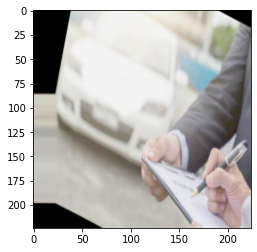

In [18]:
print(label) # tensor(1) represents damaged 
plt.imshow(img.permute(1, 2, 0) )
img.size()

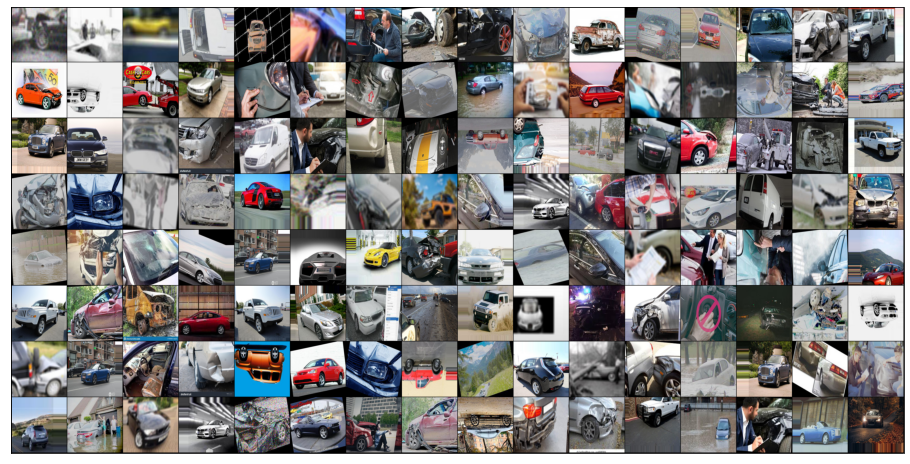

In [19]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

# new CNN

In [25]:
# Apply AlexNet
net = models.alexnet()
# hyperperemeter 
number_of_class = 2 
num_epochs = 20
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# change the number of classes to two 
net.classifier[6] = nn.Linear(4096,number_of_class)
print(net)
# path to save the model
dir = "/content/drive/MyDrive/val/model.pth"

# training
for epoch in range(num_epochs):
    running_loss, running_acc = 0.0, 0.0
    # for each batch
    for i, data in enumerate(train_loader, 1):
        img, label = data
        # import images to get output, model.forward(images) will be called
        out = net(img)
         # calculating the loss
        loss = criterion(out, label)
        # backward，Adam training
        # cleaning out the gradient for new iteration
        optimizer.zero_grad()
        # backward
        loss.backward()
        # update gradient
        optimizer.step()

        running_loss += loss.item() * label.size(0)
        _, predicted = torch.max(out, 1)
        running_acc += (predicted==label).sum().item()
        print('Epoch [{}/{}], Step(iteration) [{}/{}], Loss: {:.6f}, Acc: {:.6f}'.format(
            epoch + 1, num_epochs,i , len(train_loader), loss.item(), (predicted==label).sum().item()/batch_size))
        
    #test
    test_loss, test_acc = 0.0, 0.0
    for i, data in enumerate(test_loader):
        img, label = data

        out = net(img)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_loss += loss.item() * label.size(0)
        _, predicted = torch.max(out, 1)
        test_acc += (predicted == label).sum().item()

    print("Train {} epoch, Loss: {:.6f}, Acc: {:.6f}, Test_Loss: {:.6f}, Test_Acc: {:.6f}".format(
        epoch + 1, running_loss / (len(train_set)), running_acc / (len(train_set)),
        test_loss / (len(test_set)), test_acc / (len(test_set))))
    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, dir)



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 